In [1]:
import xarray
import pygmt
import pandas
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from matplotlib.ticker import MultipleLocator
from IPython.display import display

In [2]:
ds = xarray.open_dataset("../data/MIROC_outputs/ctrl_MIROC-COSP2.nc")

### config

In [3]:
# variables

vname='Doppler velocity'
#vname='radar reflectivity'
#vname='terminal velocity'
#vname='vertical air motion'
#vname='Ze-Doppler'
#vname='Ze-terminal'

In [4]:
# meridional zone

zone='tropics'
#zone='mid-north'
#zone='pol-north'
#zone='mid-south'
#zone='pol-south'

In [5]:
# cloud regime
#ctype='ALL'
ctype='stratiform'
#ctype='convective'

In [6]:
# only for Doppler or terminal velocity

zonal_mean_flag = True
#  True: zonal mean
# False: CFED

In [7]:
# only for terminal velocity

weight_factor='reflectivity'
#weight_factor='mass'
#weight_factor='number'

### internal process

In [8]:
%%capture
# data access

if vname=='Doppler velocity':
    if zonal_mean_flag:
        var=ds['dplrw_Z']
    else:
        var=ds['dplrw_T']
elif vname=='radar reflectivity':
    var=ds['Zef94_T']
elif vname=='terminal velocity':
    if zonal_mean_flag:
        var=ds['vfall_Z']
    else:
        var=ds['vfall_T']
elif vname=='vertical air motion':
    if zonal_mean_flag:
        var=ds['gridw_Z']
    else:
        var=ds['gridw_T']
elif vname=='Ze-Doppler':
    var=ds['ZefVd_2']
elif vname=='Ze-terminal':
    var=ds['ZefVd_2']

In [9]:
#grids

lat=ds["latitude"].values
lon=ds["longitude"].values

temp=ds["lvtemp_grid"].values
zgrd=ds["lvdBZe_grid"].values
vgrd=ds["lvdplr_grid"].values
hght=ds["levStat"].values

In [10]:
# target region
west=0. ; east=360.

if zone=='tropics':
    south=-20.0 ; north= 20.0
elif zone=='mid-north':
    south= 20.0 ; north= 65.0
elif zone=='pol-north':
    south= 65.0 ; north= 90.0
elif zone=='mid-south':
    south=-65.0 ; north=-20.0
elif zone=='pol-south':
    south=-90.0 ; north=-65.0

In [11]:
# location mask
lon_mask = (lon >= west) & (lon <= east)
lat_mask = (lat >= south)&(lat <= north)

mask = lon_mask & lat_mask

index = np.where(mask)[0]

In [12]:
# cloud regime
if ctype=='ALL':
    regime=0
elif ctype=='stratiform':
    regime=1
elif ctype=='convective':
    regime=2

In [13]:
# moment
if weight_factor=='reflectivity':
    nmlz=1
elif weight_factor=='mass':
    nmlz=2
elif weight_factor=='number':
    nmlz=3

In [14]:
if zonal_mean_flag:
    pass
else:
    if vname=='terminal velocity':
        sel = var.isel(loc=index).isel(regimeID=regime).isel(nrmlzdID=nmlz)
    else:
        sel = var.isel(loc=index).isel(regimeID=regime)
    
    if vname=='radar reflectivity':
        window = 2.0
        extent = [ -40.0, 30.0, 20.0, -80.0 ]
        xtics = 5.0 ; ytics = 10.0
        vmax = 0.2
        origin='upper'
    elif vname=='Ze-Doppler' or vname=='Ze-terminal':
        window = 2.0*0.2
        extent = [ -40.0, 30.0, -6.0, 6.0 ]
        xtics = 5.0 ; ytics = 1.0
        vmax = 3
        origin='lower'
    else:
        window = 0.2
        extent = [ -6.0, 6.0, 20.0, -80.0 ]
        xtics = 1.0 ; ytics = 10.0
        vmax = 2.0
        origin='upper'

In [15]:
if zonal_mean_flag:
    pass
else:
    if vname=='Ze-Doppler' or vname=='Ze-terminal':
        smpl = sel.sum(dim='loc', skipna=True).values
        smpl = smpl.T
        nrm = 1e-2 * window * smpl.sum()
    else:
        smpl = sel.sum(dim='loc', skipna=True).values
        nrm = window * smpl.sum(axis=1, keepdims=True)
        nrm = np.broadcast_to(nrm,smpl.shape)
    
    zero_check = (nrm < window)
    cfed = np.zeros_like(smpl)
    
    cfed[~zero_check] = smpl[~zero_check]/nrm[~zero_check]
    cfed[zero_check] = np.nan

---

In [16]:
if not zonal_mean_flag:
    pass
else:
    j_list = ( (lat + 90.0)//2.5 ).astype(int)
    Nlev = hght.size
    
    if vname=='terminal velocity':
        sel = var.isel(regimeID=regime).isel(nrmlzdID=nmlz)
    else:
        sel = var.isel(regimeID=regime)
    
    tmp = sel.sum(axis=1).values
    smpl = np.zeros((Nlev, 72), dtype=var.dtype)
    np.add.at(smpl, (slice(None), j_list), tmp)
    
    tmp = ( sel * vgrd[None,:,None] ).sum(axis=1).values
    totl = np.zeros((Nlev, 72), dtype=var.dtype)
    np.add.at(totl, (slice(None), j_list), tmp)
    
    zero_check = (smpl < 1.0)
    zmn = np.zeros_like(smpl)
    
    zmn[~zero_check] = totl[~zero_check]/smpl[~zero_check]
    zmn[zero_check]  = np.nan

In [17]:
if not zonal_mean_flag:
    pass
else:
    window = 0.2
    extent = [ -90.0, 90.0, 0.0, 14000.0 ]
    xtics = 30.0 ; ytics = 2000.0
    origin='lower'

### make figure

In [18]:
colors=np.array(
   [
    [248,248,248,1],#white
    [160,210,255,1],
    [ 33,140,255,1],
    [  0, 65,255,1],
    [  0,185,  0,1],
    [250,245,  0,1],
    [255,153,  0,1],
    [255, 40,  0,1],
    [180,  0,104,1],
    [ 45, 45, 45,1],
   ],dtype=np.float64
)
colors[:,:3] /=256
color_listed=ListedColormap(colors)
color_linear=LinearSegmentedColormap.from_list('color_linear',colors=colors)

In [19]:
tmp=np.array(
    [
    [  1, 64, 38,1],
    [ 71,108, 25,1],
    [154,125, 66,1],
    [206,185,156,1],
    [242,239,246,1],
    [236,196,225,1],
    [204,124,186,1],
    [164, 65,138,1],
    [101,  2, 75,1],
    ],dtype=np.float64
)
tmp[:,:3] /=256
near0=LinearSegmentedColormap.from_list('lower',colors=tmp)

In [20]:
tmp=np.array(
    [
    [ 26, 51, 51,1],
    [ 35, 85,130,1],
    [ 61,144,199,1],
    [120,197,204,1],
    [231,255,232,1],
    ],dtype=np.float64
)
tmp[:,:3] /=256
lower=LinearSegmentedColormap.from_list('near0',colors=tmp)

In [21]:
N1 = 128
N2 = 256

lower_linear = lower(np.linspace(0, 1, N1))
near0_linear = near0(np.linspace(0, 1, N2))

hoge = np.vstack([lower_linear, near0_linear])

zmn_color = ListedColormap(hoge)

In [22]:
%%capture
if zonal_mean_flag:
    pass
else:
    plt.ioff()
    
    fig, ax = plt.subplots(figsize=(16,9))
    im = ax.imshow(cfed,
                    extent=extent,
                    interpolation='nearest',
                    origin=origin,
                    vmin=0, vmax=vmax,
                    cmap=color_linear,
                    aspect='auto')
    
    ax.set_title("CFED: "+vname, fontsize=32, pad=16)

    if vname=='radar reflectivity':
        ax.set_xlabel("reflectivity (dB Ze)",fontsize=22)
    else:
        ax.set_xlabel("velocity (m/s)",fontsize=22)
        
    ax.set_ylabel("Temperature (degC)",fontsize=22)
    
    ax.xaxis.set_major_locator(MultipleLocator(xtics))
    ax.yaxis.set_major_locator(MultipleLocator(ytics))
    ax.tick_params(axis='both', which='major', labelsize=18)
    
    cbar = fig.colorbar(im, ax=ax,
                        orientation='vertical',
                        pad=0.02,
                        fraction=0.045,
                        shrink=1.0)
    cbar.set_label("", fontsize=13)
    cbar.ax.tick_params(labelsize=16)
    
    
    fig.tight_layout()

In [23]:
%%capture
if not zonal_mean_flag:
    pass
else:
    plt.ioff()
    
    fig, ax = plt.subplots(figsize=(16,9))
    im = ax.imshow(zmn,
                    extent=extent,
                    interpolation='nearest',
                    origin=origin,
                    vmin=-4.0, vmax=2.0,
                    cmap=zmn_color,
                    aspect='auto')

    ax.set_title("zonal mean: "+vname, fontsize=32, pad=16)

    ax.set_xlabel("latitude",fontsize=22)
    ax.set_ylabel("height",fontsize=22)
    
    ax.xaxis.set_major_locator(MultipleLocator(xtics))
    ax.yaxis.set_major_locator(MultipleLocator(ytics))
    ax.tick_params(axis='both', which='major', labelsize=18)
    
    cbar = fig.colorbar(im, ax=ax,
                        orientation='vertical',
                        pad=0.02,
                        fraction=0.045,
                        shrink=1.0)
    cbar.set_label("", fontsize=13)
    cbar.ax.tick_params(labelsize=16)
    
    
    fig.tight_layout()

### results

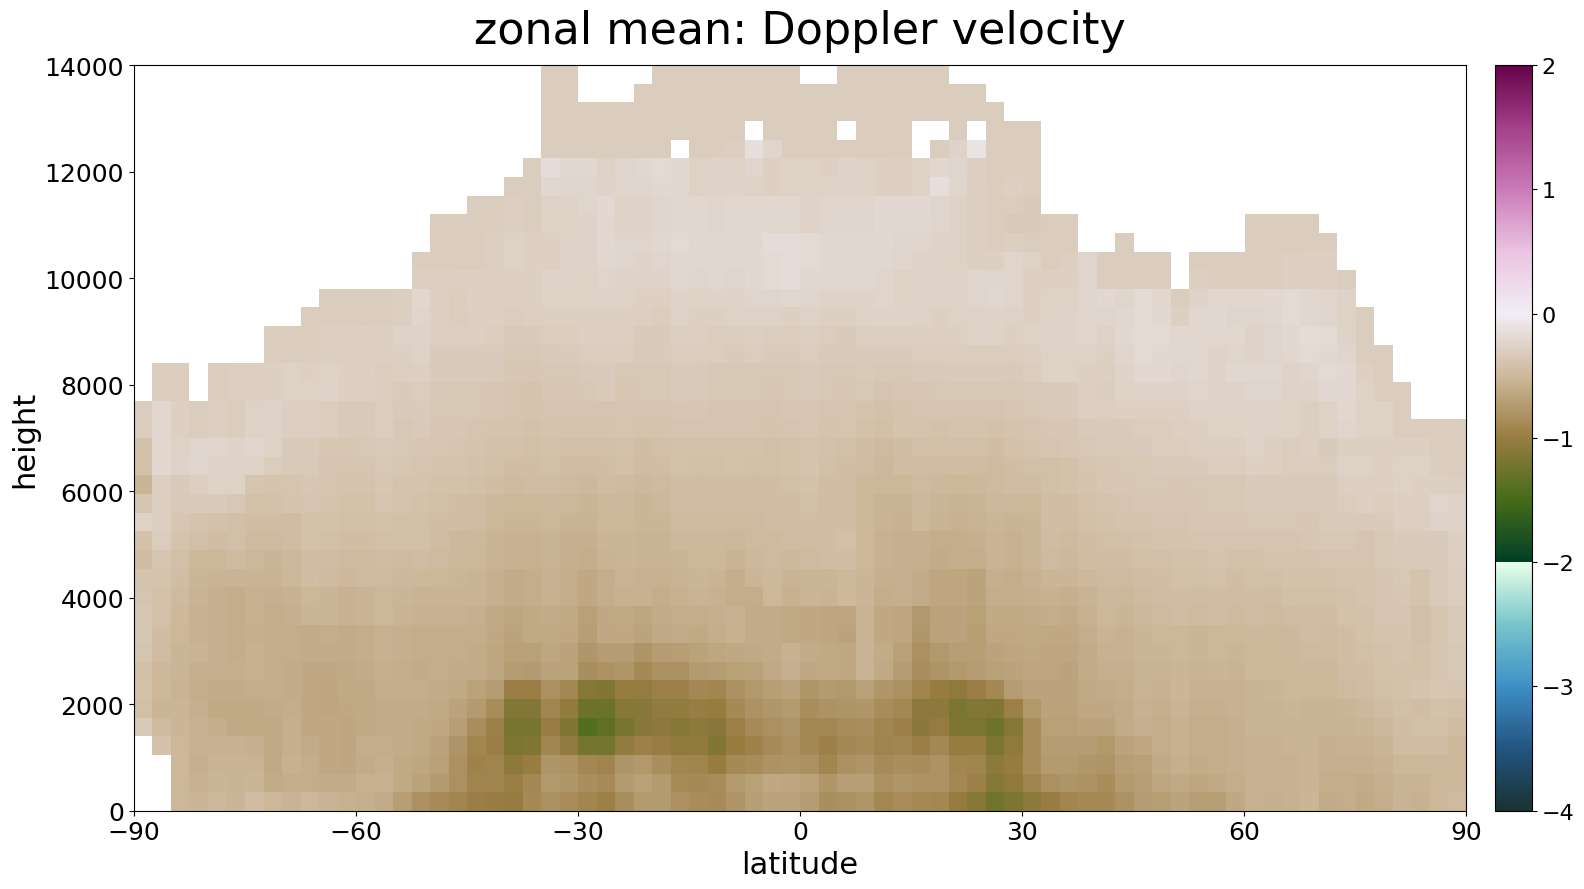

In [24]:
display(fig)